In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from os import path

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap

In [3]:
DATA_DIR = "../../data/"

In [4]:
chen_data = pd.read_csv(path.join(DATA_DIR, "chen/chen_data.csv"))
chen_data.rename({"Antibody_ID": "Ab_ID"}, axis=1, inplace=True)
chen_data.head(5)

,Ab_ID,heavy,light,Y
0,12e8,EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLE...,DIVMTQSQKFMSTSVGDRVSITCKASQNVGTAVAWYQQKPGQSPKL...,0
1,15c8,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQKPEQGLE...,DIVLTQSPAIMSASLGERVTMTCTASSSVSSSNLHWYQQKPGSSPK...,0
2,1a0q,EVQLQESDAELVKPGASVKISCKASGYTFTDHVIHWVKQKPEQGLE...,DIELTQSPSSLSASLGGKVTITCKASQDIKKYIGWYQHKPGKQPRL...,1
3,1a14,QVQLQQSGAELVKPGASVRMSCKASGYTFTNYNMYWVKQSPGQGLE...,DIELTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQNPDGTVKL...,0
4,1a2y,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,0


In [5]:
y_data = chen_data["Y"]

# Functions for projection

## PCA

In [6]:
def calculate_pca(
    x, components, plot=True
):
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(x)
    
    exp_var_pca = pca.explained_variance_ratio_
    cum_sum = np.cumsum(exp_var_pca)
    
    if plot:
        plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
        plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component index')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
    
    return X_pca

## t-SNE

In [7]:
def calculate_tsne(
    x, components, perplexity, n_iter=300, metric="euclidean"
):
    tsne = TSNE(n_components=components, verbose=1, perplexity=perplexity, n_iter=n_iter, metric=metric)
    X_embedded = tsne.fit_transform(x)
    
    return X_embedded
    

## UMAP

In [13]:
def calculate_umap(x, n_neighbors, min_dist, n_components=2, metric="euclidean"):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    embedding = reducer.fit_transform(x)
    return embedding

## Plot

In [9]:
def plot_transformed(x_pc, y, comp_to_plot=[0,1], title=None):
    df = pd.DataFrame()
    df['x'] = x_pc[:,comp_to_plot[0]]
    df['y'] = x_pc[:,comp_to_plot[1]]
    df["label"] = y
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="x", y="y",
        hue="label",
        data=df,
        legend="full",
        alpha=0.6,
        palette=['#1f76b4','orange']
    )
    if title:
        plt.title(title, fontsize=20)
    plt.show()

# BERT embeddings

In [10]:
bert_data = pd.read_feather(path.join(DATA_DIR, "chen/embeddings/bert/bert_chen_embeddings.ftr"))
bert_data = bert_data.merge(chen_data[["Ab_ID", "Y"]], how="outer", on="Ab_ID")
bert_data.head()

,Ab_ID,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,Y
0,12e8,0.000388,-0.023631,0.008127,-0.042201,0.069842,-0.020211,0.009360,-0.093598,-0.015777,...,-0.017396,-0.025206,0.006201,0.003746,0.038917,-0.032526,-0.039207,-0.014133,-0.013472,0
1,15c8,-0.007020,-0.024430,0.014849,-0.031923,0.054462,-0.025220,0.007521,-0.098703,-0.016063,...,0.021122,-0.044553,-0.009425,-0.004844,0.044911,-0.022525,-0.019677,-0.013022,-0.049844,0
2,1a0q,-0.017142,-0.008645,0.008613,-0.046730,0.061336,-0.017951,0.020446,-0.108641,0.002343,...,-0.005492,-0.037837,-0.009891,-0.018668,0.045293,-0.042225,-0.015849,-0.002904,-0.023377,1
3,1a14,-0.016770,-0.016028,0.005558,-0.022389,0.048435,-0.029777,0.005205,-0.091042,0.002346,...,0.005187,-0.027305,0.012193,0.013407,0.019745,-0.029758,-0.021011,0.000632,-0.014885,0
4,1a2y,0.022052,-0.024678,0.013147,-0.041079,0.054560,-0.009407,-0.007112,-0.076221,0.010534,...,-0.015750,-0.031617,-0.013962,-0.021564,0.045667,-0.028034,-0.023921,-0.020638,-0.019502,0


## PCA

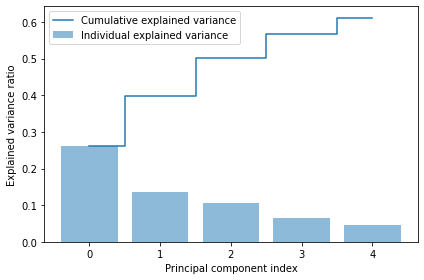

In [29]:
bert_tra = calculate_pca(bert_data.drop(["Y", "Ab_ID"], axis=1), components=5)

### Components 1 and 2

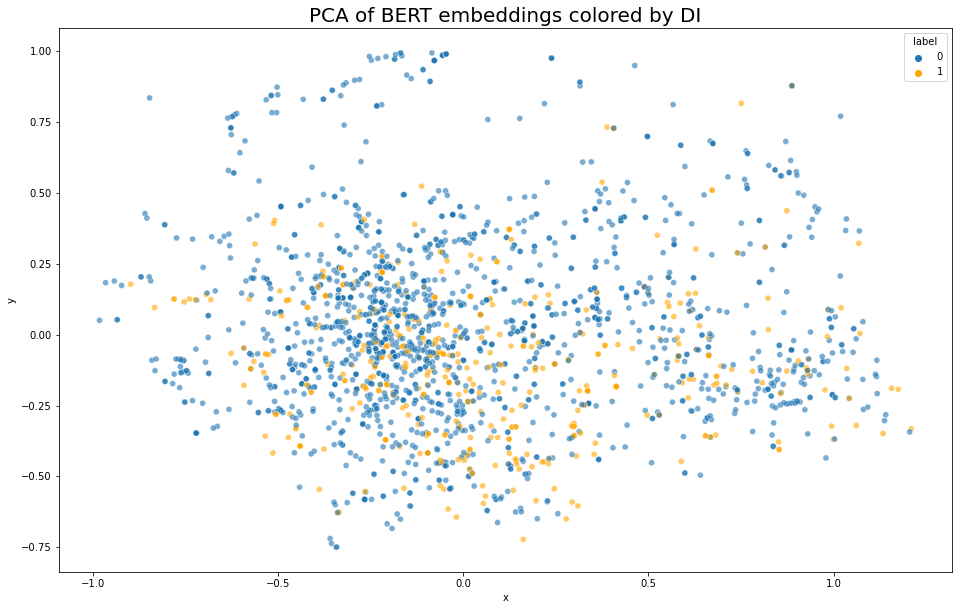

In [25]:
plot_transformed(bert_tra, bert_data["Y"], [0, 1], "PCA of BERT embeddings colored by DI")

### Components 2 and 3

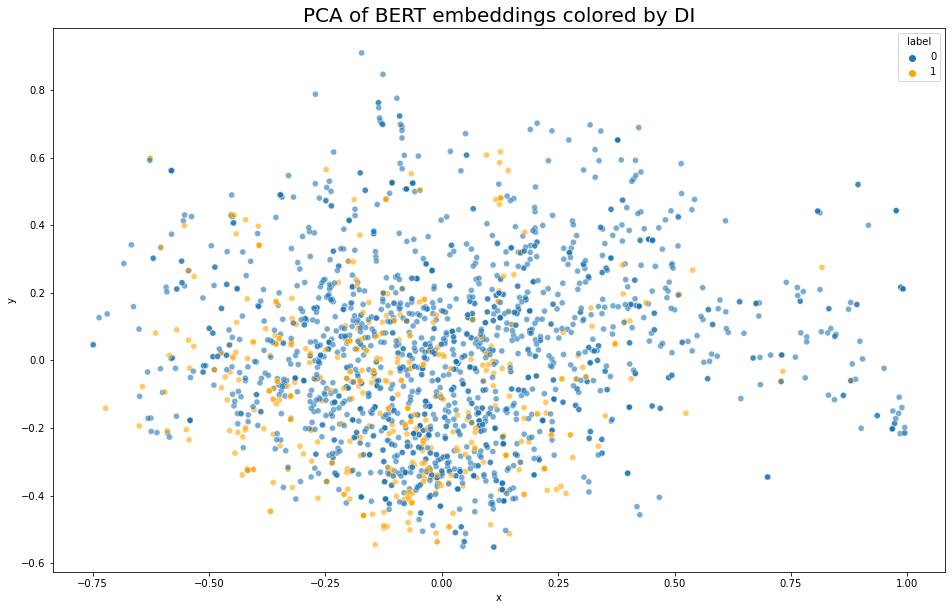

In [28]:
plot_transformed(bert_tra, bert_data["Y"], [1,2], "PCA of BERT embeddings colored by DI")

## t-SNE

In [39]:
bert_tra = calculate_tsne(bert_data.drop(["Y", "Ab_ID"], axis=1), components=3, perplexity=8)

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 2409 samples in 0.003s...
[t-SNE] Computed neighbors for 2409 samples in 0.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2409
[t-SNE] Computed conditional probabilities for sample 2000 / 2409
[t-SNE] Computed conditional probabilities for sample 2409 / 2409
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.262283
[t-SNE] KL divergence after 300 iterations: 1.233149


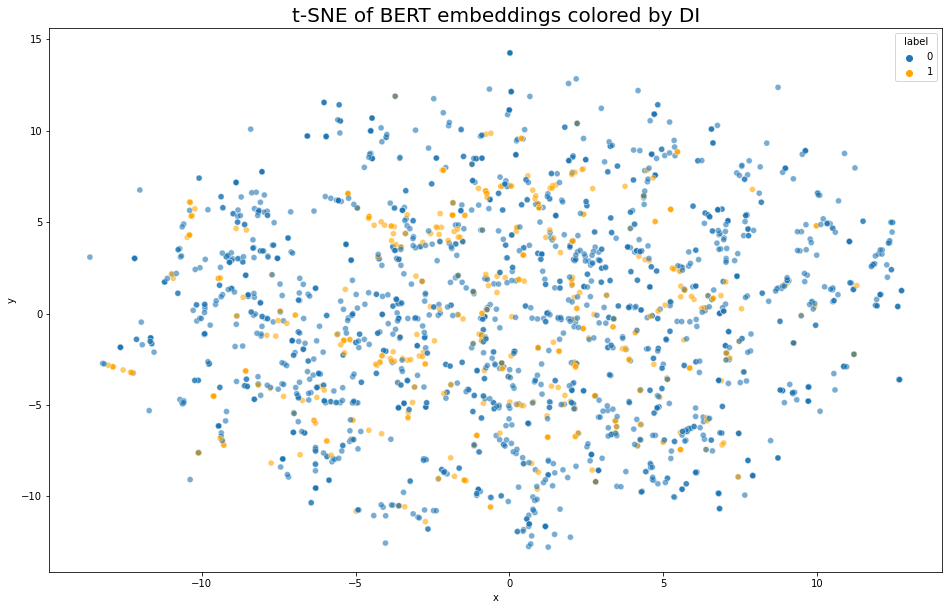

In [40]:
plot_transformed(bert_tra, bert_data["Y"], [0, 1], "t-SNE of BERT embeddings colored by DI")

In [41]:
bert_tra = calculate_tsne(bert_data.drop(["Y", "Ab_ID"], axis=1), components=3, perplexity=40, n_iter=600)

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2409 samples in 0.006s...
[t-SNE] Computed neighbors for 2409 samples in 0.621s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2409
[t-SNE] Computed conditional probabilities for sample 2000 / 2409
[t-SNE] Computed conditional probabilities for sample 2409 / 2409
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.881592
[t-SNE] KL divergence after 600 iterations: 0.614096


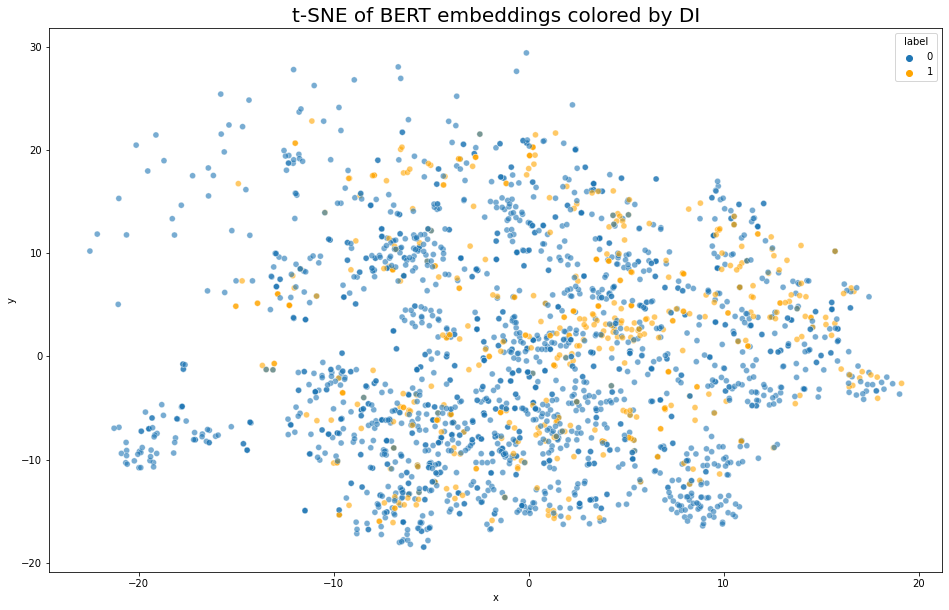

In [42]:
plot_transformed(bert_tra, bert_data["Y"], [0, 1], "t-SNE of BERT embeddings colored by DI")

## UMAP

In [22]:
bert_tra = calculate_umap(bert_data.drop(["Y", "Ab_ID"], axis=1), n_neighbors=8, min_dist=0.1)

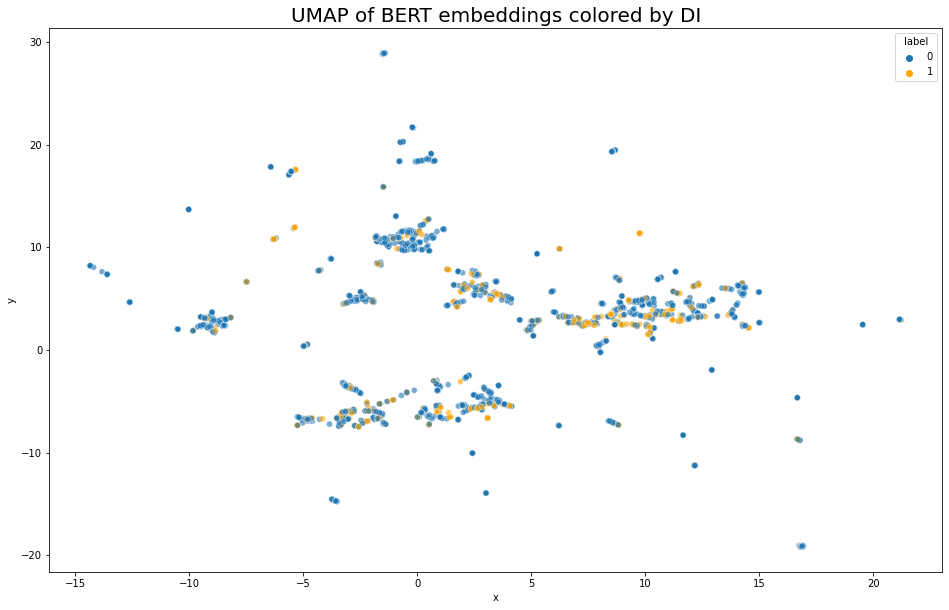

In [23]:
plot_transformed(bert_tra, bert_data["Y"], [0, 1], "UMAP of BERT embeddings colored by DI")

In [24]:
bert_tra = calculate_umap(bert_data.drop(["Y", "Ab_ID"], axis=1), n_neighbors=40, min_dist=0.2)

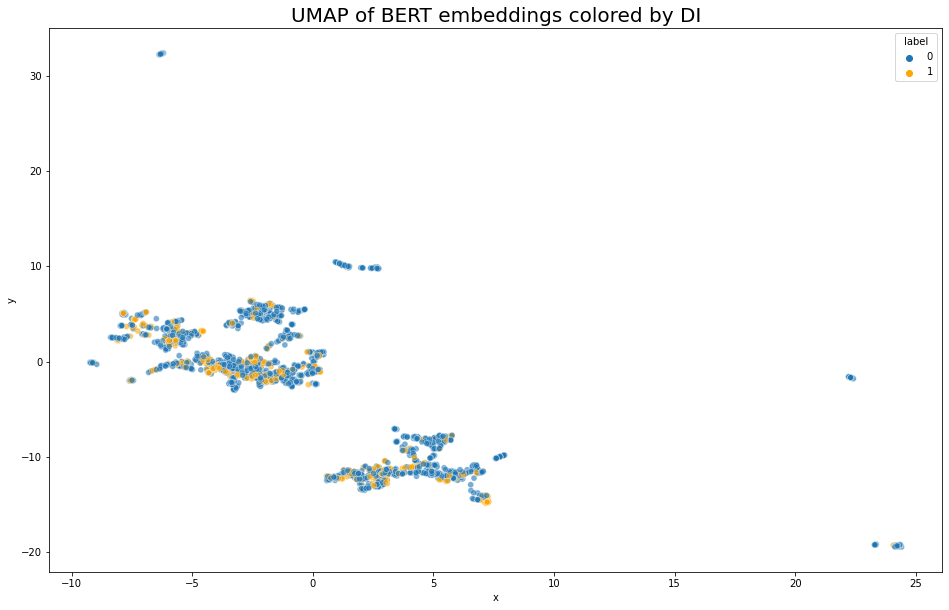

In [25]:
plot_transformed(bert_tra, bert_data["Y"], [0, 1], "UMAP of BERT embeddings colored by DI")